In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Q3: CIFAR10

##3.(I) 3 CONV + 1 FC layers CNN

100%|██████████| 170498071/170498071 [00:05<00:00, 30160189.41it/s]


Extracting /content/drive/MyDrive/EE511_Assign-3/data/cifar-10-python.tar.gz to /content/drive/MyDrive/EE511_Assign-3/data
Files already downloaded and verified
Epoch [1/100], Train Loss: 1.6049, Train Accuracy: 41.48%, Validation Loss: 1.3568, Validation Accuracy: 50.52%
Epoch [2/100], Train Loss: 1.2798, Train Accuracy: 54.08%, Validation Loss: 1.1614, Validation Accuracy: 58.51%
Epoch [3/100], Train Loss: 1.1413, Train Accuracy: 59.28%, Validation Loss: 1.0407, Validation Accuracy: 62.93%
Epoch [4/100], Train Loss: 1.0535, Train Accuracy: 62.70%, Validation Loss: 0.9816, Validation Accuracy: 65.19%
Epoch [5/100], Train Loss: 0.9933, Train Accuracy: 64.66%, Validation Loss: 0.9263, Validation Accuracy: 66.97%
Epoch [6/100], Train Loss: 0.9473, Train Accuracy: 66.29%, Validation Loss: 0.9027, Validation Accuracy: 68.86%
Epoch [7/100], Train Loss: 0.9162, Train Accuracy: 67.89%, Validation Loss: 0.8975, Validation Accuracy: 68.51%
Epoch [8/100], Train Loss: 0.8891, Train Accuracy: 68.6

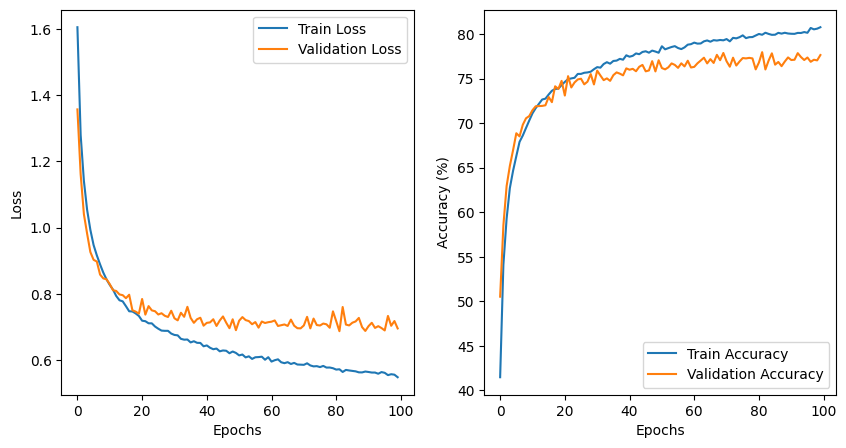

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 100
batch_size = 64
learning_rate = 0.001

# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download and load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.fc1(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training the model
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = 100 * correct_val / total_val
    val_loss = total_val_loss / len(test_loader)

    # Print and store metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

# Print test accuracy
model.eval()
with torch.no_grad():
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Train Loss: 1.7124, Train Accuracy: 36.21%, Validation Loss: 1.4249, Validation Accuracy: 47.77%
Epoch [2/50], Train Loss: 1.4759, Train Accuracy: 45.81%, Validation Loss: 1.2928, Validation Accuracy: 53.44%
Epoch [3/50], Train Loss: 1.3716, Train Accuracy: 50.13%, Validation Loss: 1.1897, Validation Accuracy: 57.92%
Epoch [4/50], Train Loss: 1.3020, Train Accuracy: 52.76%, Validation Loss: 1.1668, Validation Accuracy: 58.75%
Epoch [5/50], Train Loss: 1.2675, Train Accuracy: 54.13%, Validation Loss: 1.1325, Validation Accuracy: 60.20%
Epoch [6/50], Train Loss: 1.2256, Train Accuracy: 55.69%, Validation Loss: 1.0422, Validation Accuracy: 64.16%
Epoch [7/50], Train Loss: 1.2054, Train Accuracy: 56.57%, Validation Loss: 1.0160, Validation Accuracy: 64.21%
Epoch [8/50], Train Loss: 1.1822, Train Accuracy: 57.51%, Validation Loss: 1.0019, Validation Accuracy: 65.03%
Epoch [9/50], Train Loss: 1.1637, Tr

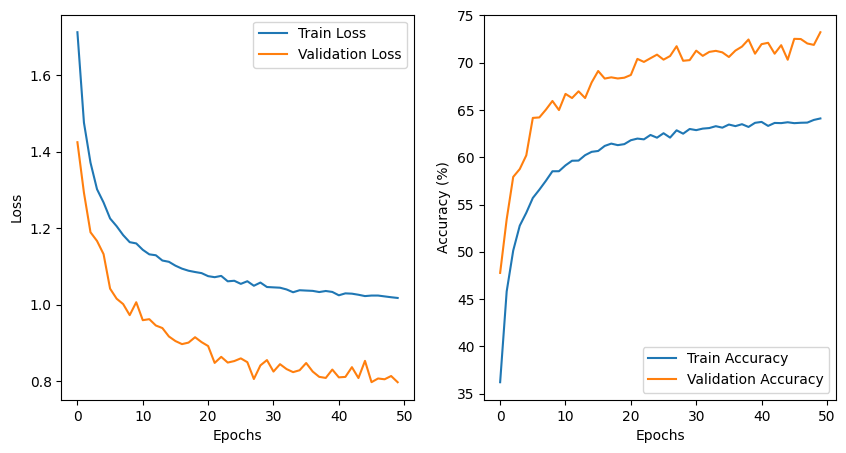

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 50
batch_size = 64
learning_rate = 0.001

# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download and load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model with dropout
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 4 * 4, 10)
        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.dropout3(x)

        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout_fc(x)
        x = self.fc1(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNNWithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training the model
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = 100 * correct_val / total_val
    val_loss = total_val_loss / len(test_loader)

    # Print and store metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

# Print test accuracy
model.eval()
with torch.no_grad():
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


#3.(II)AlexNet

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 2.3025, Train Accuracy: 0.1047, Val Loss: 2.3021, Val Accuracy: 0.1000
Epoch 2/50, Train Loss: 2.3019, Train Accuracy: 0.1108, Val Loss: 2.3009, Val Accuracy: 0.1388
Epoch 3/50, Train Loss: 2.2988, Train Accuracy: 0.1315, Val Loss: 2.2895, Val Accuracy: 0.1515
Epoch 4/50, Train Loss: 2.2078, Train Accuracy: 0.1819, Val Loss: 2.0457, Val Accuracy: 0.2577
Epoch 5/50, Train Loss: 1.9355, Train Accuracy: 0.2808, Val Loss: 1.7659, Val Accuracy: 0.3439
Epoch 6/50, Train Loss: 1.7204, Train Accuracy: 0.3551, Val Loss: 1.6281, Val Accuracy: 0.3907
Epoch 7/50, Train Loss: 1.6212, Train Accuracy: 0.3946, Val Loss: 1.5404, Val Accuracy: 0.4261
Epoch 8/50, Train Loss: 1.5484, Train Accuracy: 0.4230, Val Loss: 1.5085, Val Accuracy: 0.4407
Epoch 9/50, Train Loss: 1.4743, Train Accuracy: 0.4552, Val Loss: 1.4066, Val Accuracy: 0.4743
Epoch 10/50, Train Loss: 1.3969, Train Accuracy: 0.4824, Val Loss: 1.

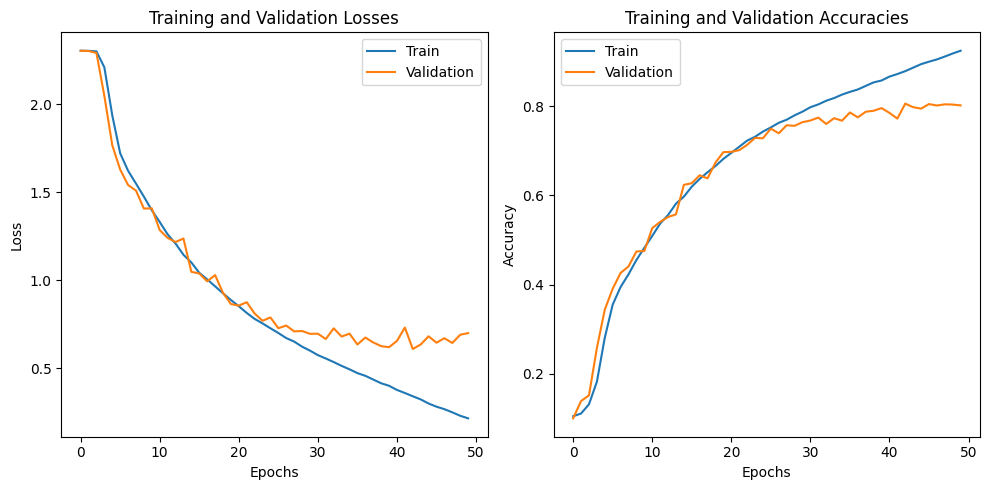

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()


In [ ]:
# Testing
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.7002, Test Accuracy: 0.8019


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 1.7388, Train Accuracy: 0.3404, Val Loss: 1.3663, Val Accuracy: 0.4978, Test Loss: 1.3663, Test Accuracy: 0.4978
Epoch 2/50, Train Loss: 1.2795, Train Accuracy: 0.5340, Val Loss: 1.1362, Val Accuracy: 0.5961, Test Loss: 1.1362, Test Accuracy: 0.5961
Epoch 3/50, Train Loss: 1.1002, Train Accuracy: 0.6054, Val Loss: 1.0525, Val Accuracy: 0.6241, Test Loss: 1.0525, Test Accuracy: 0.6241
Epoch 4/50, Train Loss: 0.9866, Train Accuracy: 0.6516, Val Loss: 0.9666, Val Accuracy: 0.6604, Test Loss: 0.9666, Test Accuracy: 0.6604
Epoch 5/50, Train Loss: 0.8940, Train Accuracy: 0.6854, Val Loss: 0.8865, Val Accuracy: 0.6947, Test Loss: 0.8865, Test Accuracy: 0.6947
Epoch 6/50, Train Loss: 0.8222, Train Accuracy: 0.7108, Val Loss: 0.8572, Val Accuracy: 0.7040, Test Loss: 0.8572, Test Accuracy: 0.7040
Epoch 7/50, Train Loss: 0.7720, Train Accuracy: 0.7279, Val Loss

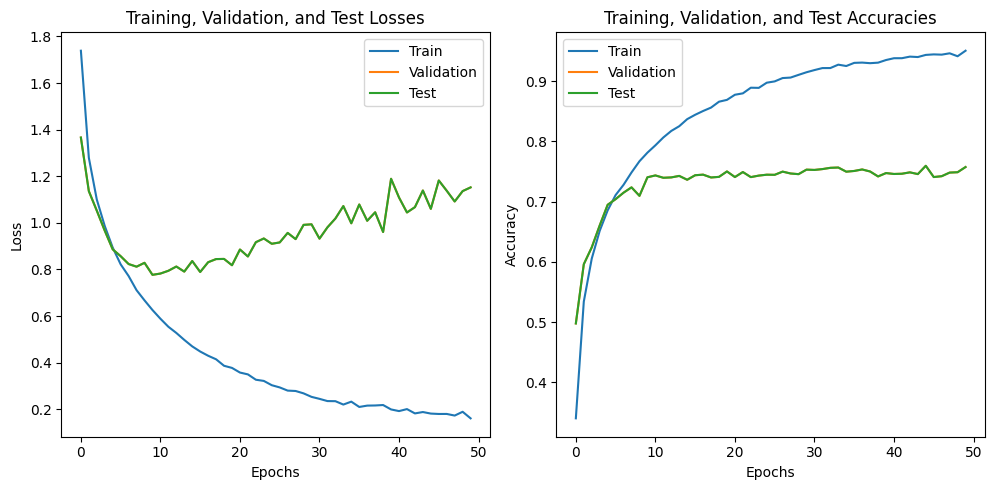

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Load CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    # Test
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_loss = running_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotting
plt.figure(figsize=(15, 5))

# Plotting losses
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training, Validation, and Test Losses')

# Plotting accuracies
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training, Validation, and Test Accuracies')

plt.tight_layout()
plt.show()


#3.(II) VGG16

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 2.2832, Train Accuracy: 0.1100, Val Loss: 2.1923, Val Accuracy: 0.1684
Epoch 2/50, Train Loss: 2.0188, Train Accuracy: 0.2340, Val Loss: 1.7987, Val Accuracy: 0.3070
Epoch 3/50, Train Loss: 1.7073, Train Accuracy: 0.3411, Val Loss: 1.5274, Val Accuracy: 0.4223
Epoch 4/50, Train Loss: 1.4591, Train Accuracy: 0.4567, Val Loss: 1.3543, Val Accuracy: 0.5044
Epoch 5/50, Train Loss: 1.2653, Train Accuracy: 0.5363, Val Loss: 1.2112, Val Accuracy: 0.5680
Epoch 6/50, Train Loss: 1.1130, Train Accuracy: 0.5974, Val Loss: 1.0654, Val Accuracy: 0.6162
Epoch 7/50, Train Loss: 0.9776, Train Accuracy: 0.6456, Val Loss: 1.0485, Val Accuracy: 0.6292
Epoch 8/50, Train Loss: 0.8735, Train Accuracy: 0.6869, Val Loss: 0.8801, Val Accuracy: 0.6944
Epoch 9/50, Train Loss: 0.7668, Train Accuracy: 0.7276, Val Loss: 0.9243, Val Accuracy: 0.6774
Epoch 10/50, Train Loss: 0.6773

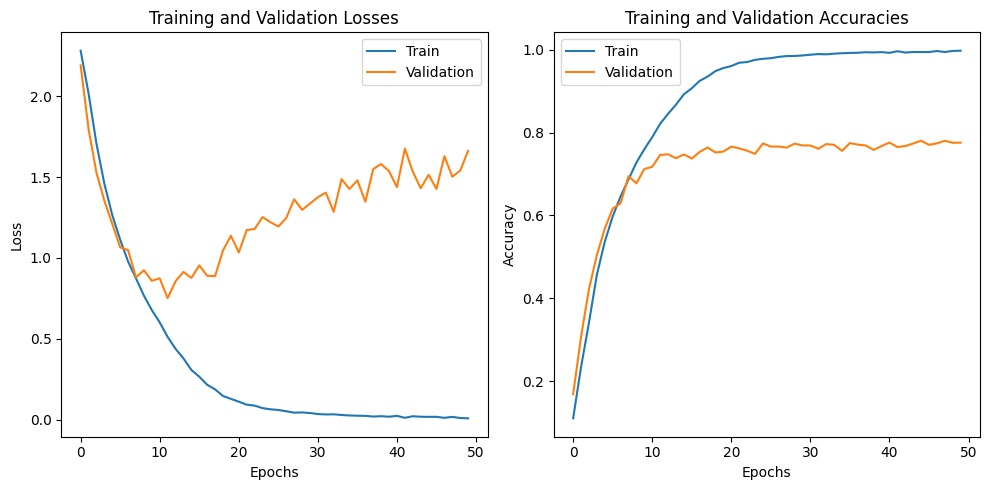

Test Loss: 1.6634, Test Accuracy: 0.7756


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# VGG16 model definition
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = torchvision.models.vgg16(pretrained=False).features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

# Testing
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


#3.(II) GoogLeNet

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 2.3009, Train Accuracy: 0.1126, Val Loss: 2.2977, Val Accuracy: 0.1528
Epoch 2/50, Train Loss: 2.2916, Train Accuracy: 0.1415, Val Loss: 2.2666, Val Accuracy: 0.1889
Epoch 3/50, Train Loss: 2.1843, Train Accuracy: 0.1922, Val Loss: 2.0451, Val Accuracy: 0.2189
Epoch 4/50, Train Loss: 2.0020, Train Accuracy: 0.2224, Val Loss: 1.9232, Val Accuracy: 0.2427
Epoch 5/50, Train Loss: 1.9012, Train Accuracy: 0.2461, Val Loss: 1.8431, Val Accuracy: 0.2655
Epoch 6/50, Train Loss: 1.8270, Train Accuracy: 0.2822, Val Loss: 1.7728, Val Accuracy: 0.3065
Epoch 7/50, Train Loss: 1.7533, Train Accuracy: 0.3200, Val Loss: 1.7262, Val Accuracy: 0.3407
Epoch 8/50, Train Loss: 1.6944, Train Accuracy: 0.3425, Val Loss: 1.6461, Val Accuracy: 0.3626
Epoch 9/50, Train Loss: 1.6492, Train Accuracy: 0.3621, Val Loss: 1.6199, Val Accuracy: 0.3818
Epoch 10/50, Train Loss: 1.6034

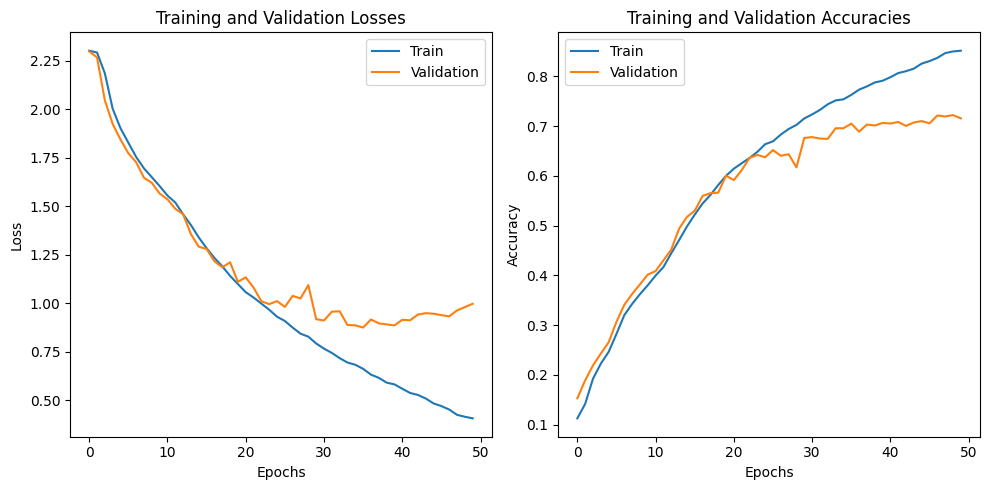

Test Loss: 0.9969, Test Accuracy: 0.7156


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch.nn.functional as F

class BasicInceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, out1x1pool):
        super(BasicInceptionModule, self).__init__()

        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce3x3, kernel_size=1),
            nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, reduce5x5, kernel_size=1),
            nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)
        )

        self.branch1x1pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch1x1pool = self.branch1x1pool(x)

        outputs = [branch1x1, branch3x3, branch5x5, branch1x1pool]
        return torch.cat(outputs, 1)

class GoogleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogleNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception3a = BasicInceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = BasicInceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(480, 4096),  # Adjust the input size here
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.inception3a(x)
        x = self.inception3b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x




# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use SGD with Momentum

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

# Testing
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch.nn.functional as F

class BasicInceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, out1x1pool):
        super(BasicInceptionModule, self).__init__()

        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce3x3, kernel_size=1),
            nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, reduce5x5, kernel_size=1),
            nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)
        )

        self.branch1x1pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch1x1pool = self.branch1x1pool(x)

        outputs = [branch1x1, branch3x3, branch5x5, branch1x1pool]
        return torch.cat(outputs, 1)

class GoogleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogleNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception3a = BasicInceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = BasicInceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(480, 4096),  # Adjust the input size here
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.inception3a(x)
        x = self.inception3b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x




# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogleNet().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use SGD with Momentum
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

# Testing
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


100%|██████████| 170498071/170498071 [00:01<00:00, 102736737.84it/s]


Extracting /content/drive/MyDrive/EE511_Assign-3/data/cifar-10-python.tar.gz to /content/drive/MyDrive/EE511_Assign-3/data
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100, Train Loss: 1.6518, Train Accuracy: 0.3709, Val Loss: 1.4645, Val Accuracy: 0.4529
Epoch 2/100, Train Loss: 1.2747, Train Accuracy: 0.5368, Val Loss: 1.1610, Val Accuracy: 0.5884
Epoch 3/100, Train Loss: 1.1181, Train Accuracy: 0.6005, Val Loss: 1.0236, Val Accuracy: 0.6465
Epoch 4/100, Train Loss: 1.0099, Train Accuracy: 0.6440, Val Loss: 1.0116, Val Accuracy: 0.6432
Epoch 5/100, Train Loss: 0.9375, Train Accuracy: 0.6712, Val Loss: 0.9811, Val Accuracy: 0.6571
Epoch 6/100, Train Loss: 0.8833, Train Accuracy: 0.6943, Val Loss: 0.9375, Val Accuracy: 0.6839
Epoch 7/100, Train Loss: 0.8364, Train Accuracy: 0.7096, Val Loss: 0.8722, Val Accuracy: 0.7021
Epoch 8/100, Train Loss: 0.7978, Train Accuracy: 0.7228, Val Loss: 0.8578, Val Accuracy: 0.7095
Epoch 9/100, Train Loss: 0.7685, 

#3.(II) ResNet152

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 1.6013, Train Accuracy: 0.4166, Val Loss: 1.3389, Val Accuracy: 0.5092
Epoch 2/50, Train Loss: 1.1810, Train Accuracy: 0.5809, Val Loss: 1.0891, Val Accuracy: 0.6143
Epoch 3/50, Train Loss: 0.9662, Train Accuracy: 0.6604, Val Loss: 1.0410, Val Accuracy: 0.6393
Epoch 4/50, Train Loss: 0.8293, Train Accuracy: 0.7114, Val Loss: 0.9029, Val Accuracy: 0.6879
Epoch 5/50, Train Loss: 0.7081, Train Accuracy: 0.7561, Val Loss: 0.9186, Val Accuracy: 0.6856
Epoch 6/50, Train Loss: 0.6208, Train Accuracy: 0.7838, Val Loss: 0.8700, Val Accuracy: 0.7080
Epoch 7/50, Train Loss: 0.5269, Train Accuracy: 0.8157, Val Loss: 0.9246, Val Accuracy: 0.6974
Epoch 8/50, Train Loss: 0.4504, Train Accuracy: 0.8444, Val Loss: 0.8991, Val Accuracy: 0.7136
Epoch 9/50, Train Loss: 0.3812, Train Accuracy: 0.8658, Val Loss: 0.9663, Val Accuracy: 0.7098
Epoch 10/50, Train Loss: 0.3320

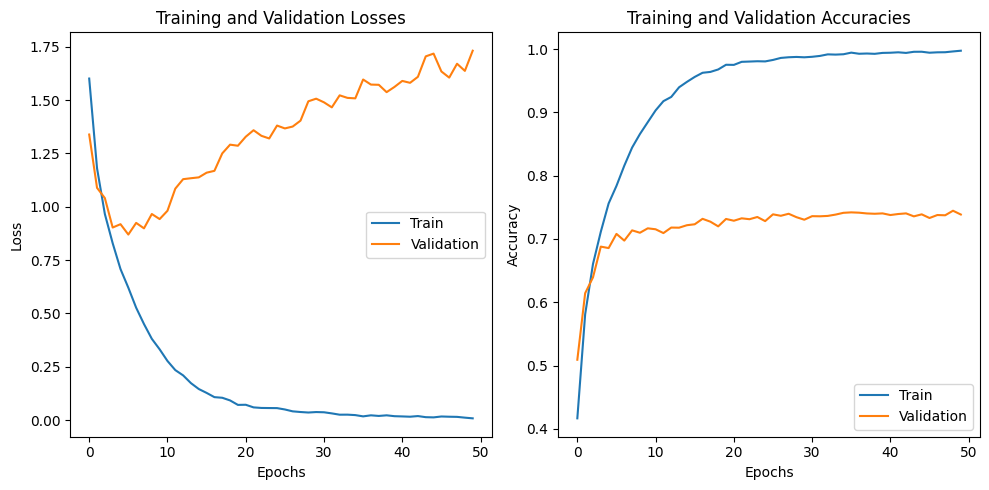

Test Loss: 1.7318, Test Accuracy: 0.7386


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

# Define the ResNet-152 model
class ResNet152(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet152, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResidualBlock, 64, 3, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, 8, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 36, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)  # Adjust the input size here

    def _make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, channels, stride))
            self.in_channels = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet152().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use SGD with Momentum

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

# Testing
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


#3.(II) EfficientNet-b1

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 1.7331, Train Accuracy: 0.3597, Val Loss: 1.4320, Val Accuracy: 0.4798
Epoch 2/50, Train Loss: 1.3617, Train Accuracy: 0.5058, Val Loss: 1.3012, Val Accuracy: 0.5280
Epoch 3/50, Train Loss: 1.2100, Train Accuracy: 0.5634, Val Loss: 1.2122, Val Accuracy: 0.5649
Epoch 4/50, Train Loss: 1.0996, Train Accuracy: 0.6054, Val Loss: 1.1535, Val Accuracy: 0.5880
Epoch 5/50, Train Loss: 1.0049, Train Accuracy: 0.6393, Val Loss: 1.1442, Val Accuracy: 0.5947
Epoch 6/50, Train Loss: 0.9219, Train Accuracy: 0.6721, Val Loss: 1.1319, Val Accuracy: 0.6127
Epoch 7/50, Train Loss: 0.8402, Train Accuracy: 0.7006, Val Loss: 1.1423, Val Accuracy: 0.6098
Epoch 8/50, Train Loss: 0.7728, Train Accuracy: 0.7257, Val Loss: 1.1484, Val Accuracy: 0.6116
Epoch 9/50, Train Loss: 0.7177, Train Accuracy: 0.7450, Val Loss: 1.1618, Val Accuracy: 0.6149
Epoch 10/50, Train Loss: 0.6506

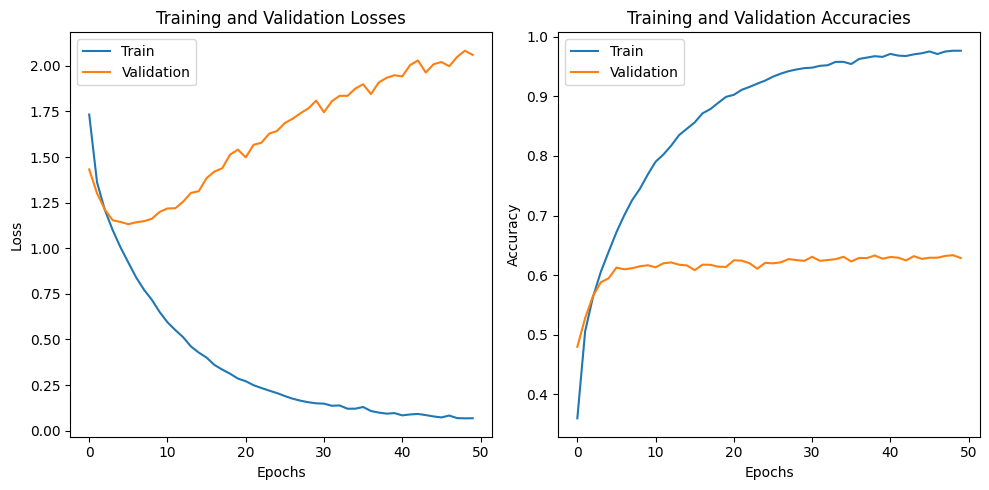

Test Loss: 2.0600, Test Accuracy: 0.6287


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MBConv block
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, kernel_size, stride, se_ratio=0.25):
        super(MBConvBlock, self).__init__()

        self.expand_channels = int(in_channels * expand_ratio)
        self.use_se = se_ratio is not None and 0 < se_ratio <= 1

        # Expansion phase
        self.expand_conv = nn.Conv2d(in_channels, self.expand_channels, kernel_size=1, bias=False)
        self.expand_bn = nn.BatchNorm2d(self.expand_channels)
        self.expand_swish = Swish()

        # Depthwise convolution
        self.dw_conv = nn.Conv2d(
            self.expand_channels,
            self.expand_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=kernel_size // 2,
            groups=self.expand_channels,
            bias=False
        )
        self.dw_bn = nn.BatchNorm2d(self.expand_channels)
        self.dw_swish = Swish()

        # Squeeze and Excitation phase
        if self.use_se:
            self.se = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(self.expand_channels, int(self.expand_channels * se_ratio), kernel_size=1),
                Swish(),
                nn.Conv2d(int(self.expand_channels * se_ratio), self.expand_channels, kernel_size=1),
                nn.Sigmoid()
            )

        # Output phase
        self.project_conv = nn.Conv2d(self.expand_channels, out_channels, kernel_size=1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # Expansion
        out = self.expand_swish(self.expand_bn(self.expand_conv(x)))

        # Depthwise convolution
        out = self.dw_swish(self.dw_bn(self.dw_conv(out)))

        # Squeeze and Excitation
        if self.use_se:
            se_weights = self.se(out)
            out = out * se_weights

        # Output phase
        out = self.project_bn(self.project_conv(out))

        # Skip connection if input and output shapes are the same
        if x.shape[1] == out.shape[1]:
            out = out + x

        return out

# Define the EfficientNet model
class EfficientNetB1(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetB1, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            Swish(),
            MBConvBlock(32, 16, 1, 3, 1),
            MBConvBlock(16, 24, 6, 3, 2),
            MBConvBlock(24, 40, 6, 5, 2),
            MBConvBlock(40, 80, 6, 3, 2),
            MBConvBlock(80, 112, 6, 5, 1),
            MBConvBlock(112, 192, 6, 5, 2),
            MBConvBlock(192, 320, 6, 3, 1),
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            Swish(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use SGD with Momentum

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

# Testing
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 2.1763, Train Accuracy: 0.1970, Val Loss: 2.0453, Val Accuracy: 0.2535
Epoch 2/50, Train Loss: 1.9132, Train Accuracy: 0.2958, Val Loss: 1.8473, Val Accuracy: 0.3247
Epoch 3/50, Train Loss: 1.7600, Train Accuracy: 0.3551, Val Loss: 1.7223, Val Accuracy: 0.3746
Epoch 4/50, Train Loss: 1.6497, Train Accuracy: 0.3952, Val Loss: 1.6417, Val Accuracy: 0.3994
Epoch 5/50, Train Loss: 1.5716, Train Accuracy: 0.4283, Val Loss: 1.5853, Val Accuracy: 0.4245
Epoch 6/50, Train Loss: 1.5068, Train Accuracy: 0.4521, Val Loss: 1.5379, Val Accuracy: 0.4431
Epoch 7/50, Train Loss: 1.4516, Train Accuracy: 0.4737, Val Loss: 1.5069, Val Accuracy: 0.4534
Epoch 8/50, Train Loss: 1.4039, Train Accuracy: 0.4929, Val Loss: 1.4706, Val Accuracy: 0.4675
Epoch 9/50, Train Loss: 1.3646, Train Accuracy: 0.5081, Val Loss: 1.4514, Val Accuracy: 0.4749
Epoch 10/50, Train Loss: 1.3298

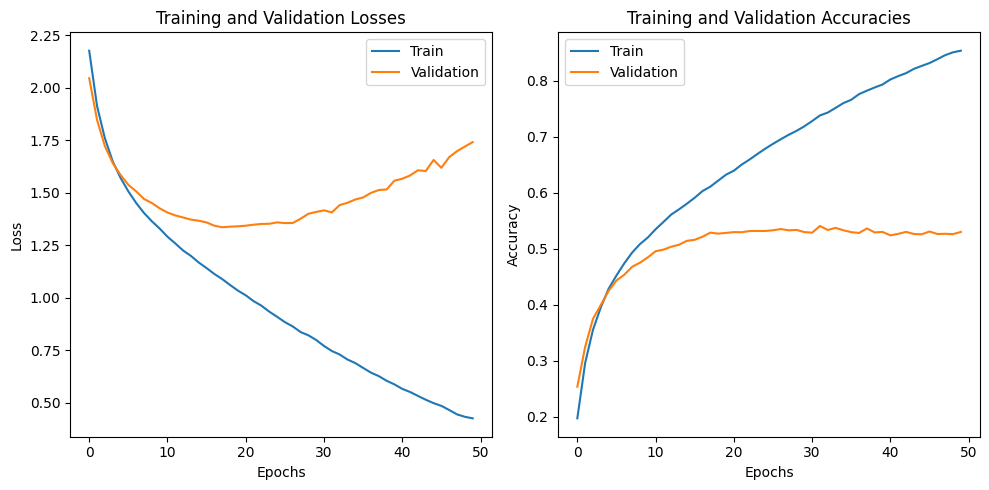

Test Loss: 1.7412, Test Accuracy: 0.5298


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Define the MBConv block
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, kernel_size, stride, se_ratio=0.25):
        super(MBConvBlock, self).__init__()

        self.expand_channels = int(in_channels * expand_ratio)
        self.use_se = se_ratio is not None and 0 < se_ratio <= 1

        # Expansion phase
        self.expand_conv = nn.Conv2d(in_channels, self.expand_channels, kernel_size=1, bias=False)
        self.expand_bn = nn.BatchNorm2d(self.expand_channels)
        self.expand_swish = Swish()

        # Depthwise convolution
        self.dw_conv = nn.Conv2d(
            self.expand_channels,
            self.expand_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=kernel_size // 2,
            groups=self.expand_channels,
            bias=False
        )
        self.dw_bn = nn.BatchNorm2d(self.expand_channels)
        self.dw_swish = Swish()

        # Squeeze and Excitation phase
        if self.use_se:
            self.se = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(self.expand_channels, int(self.expand_channels * se_ratio), kernel_size=1),
                Swish(),
                nn.Conv2d(int(self.expand_channels * se_ratio), self.expand_channels, kernel_size=1),
                nn.Sigmoid()
            )

        # Output phase
        self.project_conv = nn.Conv2d(self.expand_channels, out_channels, kernel_size=1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # Expansion
        out = self.expand_swish(self.expand_bn(self.expand_conv(x)))

        # Depthwise convolution
        out = self.dw_swish(self.dw_bn(self.dw_conv(out)))

        # Squeeze and Excitation
        if self.use_se:
            se_weights = self.se(out)
            out = out * se_weights

        # Output phase
        out = self.project_bn(self.project_conv(out))

        # Skip connection if input and output shapes are the same
        if x.shape[1] == out.shape[1]:
            out = out + x

        return out

# Define the EfficientNet model
class EfficientNetB1(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetB1, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            Swish(),
            MBConvBlock(32, 16, 1, 3, 1),
            MBConvBlock(16, 24, 6, 3, 2),
            MBConvBlock(24, 40, 6, 5, 2),
            MBConvBlock(40, 80, 6, 3, 2),
            MBConvBlock(80, 112, 6, 5, 1),
            MBConvBlock(112, 192, 6, 5, 2),
            MBConvBlock(192, 320, 6, 3, 1),
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            Swish(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/EE511_Assign-3/data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)  # Use SGD with Momentum

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

# Testing
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
